In [150]:
from typing import Tuple, List, Dict
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import (alexnet,
                                AlexNet_Weights,
                                resnet18,
                                ResNet18_Weights,
                                ResNet,
                                resnet101)

from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


In [145]:
class NeuralImageCompressor(nn.Module):
    def __init__(self,
                 encoder: nn.Module,
                 decoder: nn.Module,
                 normalising_activation: nn.Module = nn.Sigmoid(),
                 B: int = 1):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.normalising_activation = normalising_activation
        self.B = B
            
    def _get_quantization_error(self, shape: Tuple[int, ...]):
        mean = torch.full(shape, -0.5)
        std = torch.full(shape, 0.5)
        return 0.5**self.B * torch.normal(mean = mean, std = std)
    
    def forward(self, x):
        out = self.encoder(x)
        out = self.normalising_activation(out)
        out += self._get_quantization_error(out.shape)
        out = self.decoder(out)
        return out

In [28]:
class AutoencoderAlexNet(NeuralImageCompressor):
    def __init__(self, B: int = 1, normalising_activation: nn.Module = nn.Sigmoid()):
        encoder = alexnet(weights=AlexNet_Weights.DEFAULT).features
        decoder = self._get_decoder(encoder)
        super().__init__(encoder, decoder, normalising_activation, B)
    
    @staticmethod
    def _get_decoder(encoder: nn.Sequential):
        decoder_modules = []

        for module in reversed(encoder):
            if isinstance(module, nn.Conv2d):
                trans_conv = nn.ConvTranspose2d(
                    in_channels=module.out_channels,
                    out_channels=module.in_channels,
                    kernel_size=module.kernel_size,
                    stride=module.stride,
                    padding=module.padding
                )
                decoder_modules.append(trans_conv)
            elif isinstance(module, nn.ReLU):
                decoder_modules.append(nn.ReLU(inplace=True))
            elif isinstance(module, nn.MaxPool2d):
                # We can use MaxUnpool if we're going to save MaxPool indicies
                # unpool = nn.MaxUnpool2d(
                #     kernel_size=module.kernel_size,
                #     stride=module.stride,
                #     padding=module.padding
                # )
                upsample = nn.Upsample(
                    scale_factor=2,
                    mode='nearest'
                )
                decoder_modules.append(upsample)
            else:
                raise ValueError(f"unexpected module {module}")
            
        decoder = nn.Sequential(*decoder_modules)
        return decoder

In [29]:
alexnet_autoencoder = AutoencoderAlexNet()

test_image = torch.rand(3, 256, 256)

alexnet_autoencoder(test_image.unsqueeze(0)).shape

torch.Size([1, 3, 227, 227])

In [30]:
class AutoEncoderResNet(NeuralImageCompressor):
    def __init__(self, resnet: ResNet, decoder: nn.Module,
                 normalising_activation: nn.Module = nn.Sigmoid(), B: int = 1):
        encoder = self._get_resnet_encoder(resnet)
        super().__init__(encoder, decoder, normalising_activation, B)
    
    @staticmethod
    def _get_resnet_encoder(resnet: ResNet):
        return nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4)

In [31]:
def decoder_8x_upsample_constructor(in_chan_num):
    out_chan_nums = [512, 256, 128, 64, 3]

    decoder_modules = []

    for out_chan_num in out_chan_nums:
        decoder_modules.append(
            nn.Sequential(
                nn.Upsample(
                    scale_factor=2,
                    mode='nearest'
                ),
                nn.Conv2d(in_channels=in_chan_num, out_channels=out_chan_num, kernel_size=3, stride=1, padding=1),
                nn.ReLU()
            )
        )

        in_chan_num = out_chan_num
    
    return nn.Sequential(*decoder_modules)

In [32]:
def resnet_encoder_constructor(resnet):
    return nn.Sequential(
        resnet.conv1,
        resnet.bn1,
        resnet.relu,
        resnet.maxpool,
        resnet.layer1,
        resnet.layer2,
        resnet.layer3,
        resnet.layer4)

In [151]:
def create_resnet_autoencoder(resnet: ResNet, decoder_in_channels = 512):
    resnet_encoder = resnet_encoder_constructor(resnet)
    decoder_8x_upsample = decoder_8x_upsample_constructor(decoder_in_channels)
    resnet_autoencoder = NeuralImageCompressor(resnet_encoder, decoder_8x_upsample, nn.Sigmoid(), 1)
    return resnet_autoencoder


resnet_autoencoder = create_resnet_autoencoder(resnet18(weights=ResNet18_Weights.DEFAULT))

In [152]:
test_image = torch.rand(3, 64, 64)
resnet_autoencoder(test_image.unsqueeze(0)).shape

torch.Size([1, 3, 64, 64])

In [153]:
two_test_images = torch.rand(2, 3, 32, 32)
resnet_autoencoder(two_test_images).shape

torch.Size([2, 3, 32, 32])

In [36]:
# def get_output_channels_of_resnet_encoder(resnet_encoder):
#     num_out_channels = None
#     for module in reversed(resnet_encoder[-1][-1]):
#         if isinstance(module, nn.Conv2d):
#             last_conv = module
#             num_out_channels = module.out_channels
#     return num_out_channels

In [37]:
# list(resnet_encoder[-1][-1].children())

In [38]:
# Upsampling with transposed convolution

import torch
import torch.nn as nn

input_size = (3, 16, 16)  # Input tensor size (channels, height, width)
output_channels = 3  # Number of output channels
kernel_size = 4  # Kernel size in the transpose convolution
stride = 2  # Stride in the transpose convolution
padding = 1  # Padding in the transpose convolution

# Create a random input tensor
input_tensor = torch.randn(1, *input_size)

# Define the transpose convolution layer
trans_conv = nn.ConvTranspose2d(
    in_channels=input_size[0],
    out_channels=output_channels,
    kernel_size=kernel_size,
    stride=stride,
    padding=padding
)

# Apply the transpose convolution to the input tensor
output_tensor = trans_conv(input_tensor)

# Check the size of the output tensor
print("Input size:", input_tensor.size())
print("Output size:", output_tensor.size())

Input size: torch.Size([1, 3, 16, 16])
Output size: torch.Size([1, 3, 32, 32])


In [39]:
a = list(os.listdir(
    "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01443537"
))

In [17]:
# datasets_path = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC" 
# train_path = os.path.join(datasets_path, "train")
# transform = None
# train_dataset = ImageFolder(root=train_path,transform = transform)

In [66]:
import skimage.io
from PIL import Image 

class ImageFolderSelectedDirs(Dataset):
    def __init__(self, root, dirs=None, transform=None):
        self.root = root
        self.dirs = dirs
        self.transform = transform
        self.images = []
        self._set_images()
    
    def _set_images(self):
        for dir_name in self.dirs:
            dir_path = os.path.join(self.root, dir_name)
            for filename in os.listdir(dir_path):
                self.images.append(
                    os.path.join(
                        dir_path,
                        filename))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.get_image(idx)
        if self.transform:
            image = self.transform(image)
        return image
    
    def get_image(self, idx):
        image_path = self.images[idx]
        image = skimage.io.imread(image_path)
        image = Image.fromarray(image)
        return image

In [118]:
from torchvision.transforms.functional import pad
from torchvision import transforms
import numpy as np
import numbers

class PadDivisibleBy32(object):
    def __init__(self, fill=0, padding_mode='constant'):
        assert isinstance(fill, (numbers.Number, str, tuple))
        assert padding_mode in ['constant', 'edge', 'reflect', 'symmetric']

        self.fill = fill
        self.padding_mode = padding_mode
        
    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be padded.

        Returns:
            PIL Image: Padded image.
        """
        return F.pad(img, self._get_padding(img), self.padding_mode, self.fill)
    
    def __repr__(self):
        return self.__class__.__name__ + '(padding={0}, fill={1}, padding_mode={2})'.\
            format(self.fill, self.padding_mode)
    
    @staticmethod
    def _get_padding(image):  
        ch, w, h = image.shape

        w_pad = w%32
        h_pad = h%32

        l_pad = w_pad//2 + w_pad%2
        r_pad = w_pad//2

        t_pad = h_pad//2 + h_pad%2
        b_pad = h_pad//2 
                    
        return int(l_pad), int(t_pad), int(r_pad), int(b_pad)

In [119]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
imagenet_normalize = transforms.Normalize(imagenet_mean, imagenet_std)

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        PadDivisibleBy32(),
        imagenet_normalize
    ]),
    'val': transforms.Compose([
        PadDivisibleBy32(),
        transforms.ToTensor(),
        PadDivisibleBy32(),
        imagenet_normalize
    ]),
}

In [120]:
# datasets_root = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC"
# dirs = dirname_to_classname.keys() 
# phases = ["train", "val"]

# dataset_paths = {phase: os.path.join(datasets_path, phase) for phase in phases}
# datasets = {phase: ImageFolderSelectedDirs(root = dataset_paths[phase], dirs = dirs, transform = data_transforms[phase]) for phase in phases}

In [121]:
dirname_to_classname = {
    "n02486410": "baboon",
    "n07720875": "bell pepper",
    "n03124170": "cowboy hat",
    "n02493509": "titi, titi monkey",
    "n02110627": "affenpinscher, monkey pinscher, monkey dog",
    "n02493793": "spider monkey, Ateles geoffroyi",
}

In [122]:
# for k in dirname_to_classname.keys():
#     print(f"{k} in class_indx = {k in class_idxs}")

class_idxs = os.listdir("/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train")
all(k in class_idxs for k in dirname_to_classname.keys())

True

In [123]:
datasets_root = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC"
dirs = dirname_to_classname.keys() 
phases = ["train", "val"]

train_data_transform = data_transforms["train"]
train_dataset_path  = os.path.join(datasets_path, "train")
train_dataset = ImageFolderSelectedDirs(
    root = train_dataset_path,
    dirs = dirs,
    transform = train_data_transform)

In [124]:
len(train_dataset)

7454

In [125]:
train_dataset[3150]

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

In [126]:
type(train_dataset.get_image(3150))

PIL.Image.Image

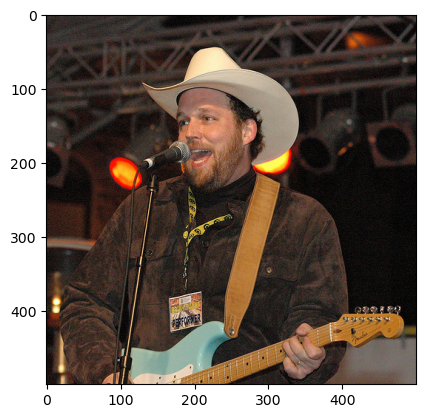

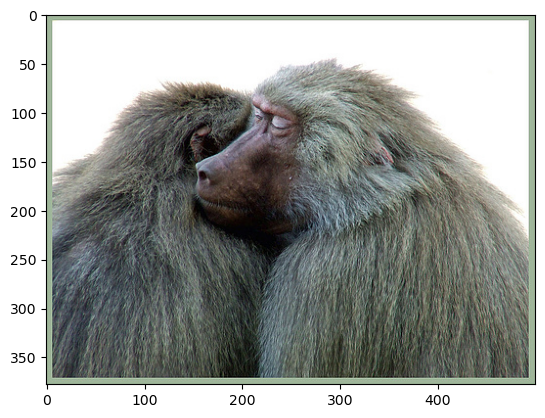

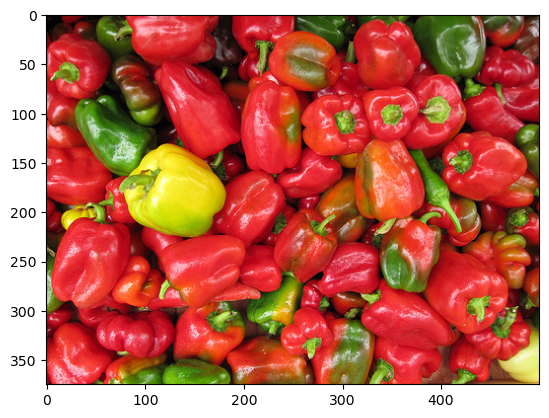

In [127]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset.get_image(3150))
plt.show()
plt.imshow(train_dataset.get_image(120))
plt.show()
plt.imshow(train_dataset.get_image(1390))
plt.show()

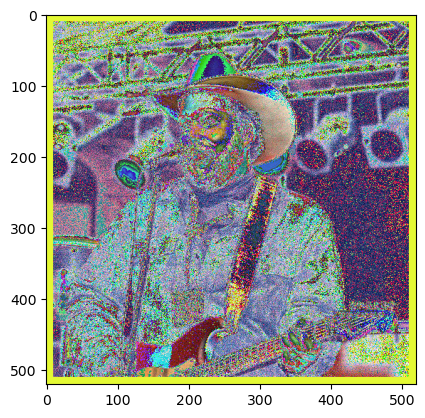

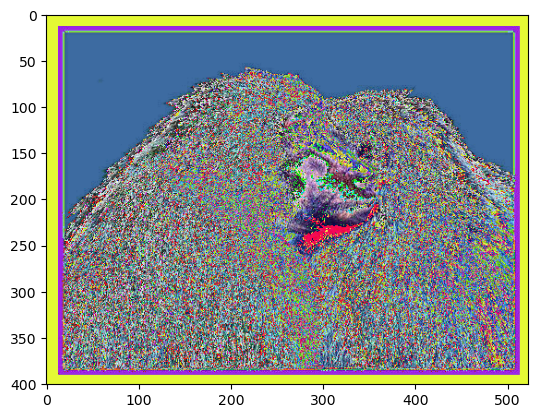

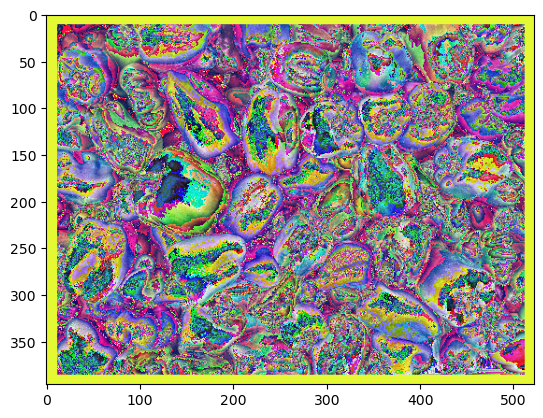

In [128]:
to_pil = transforms.functional.to_pil_image
    
import matplotlib.pyplot as plt
plt.imshow(to_pil(train_dataset[3150]))
plt.show()
plt.imshow(to_pil(train_dataset[120]))
plt.show()
plt.imshow(to_pil(train_dataset[1390]))
plt.show()

In [131]:
train_dataset[1].shape

torch.Size([3, 349, 517])

In [132]:
340%32

20

In [84]:
509%32

29

In [160]:
def train(model, optimizer, criterion,
          dataloaders: Dict[str, DataLoader], epochs,
          phases: List[str] = ["train", "val"]):
    for epoch in range(epochs):
        for phase in phases:
            if phase not in ["train", "val"]:
                raise ValueError('phases cannot contain a phae other than "train" or "val"')
            dataloaders[phase]
            
            pbar = tqdm(
                dataloaders[phase],
                total=len(dataloaders[phase]))
            
            for image in pbar:
                pass

In [161]:
dummy_datasets = {"train": train_dataset, "val": train_dataset}
dummy_dataloaders = {
    "train": DataLoader(train_dataset, batch_size = 16, shuffle = True),
    "val": DataLoader(train_dataset, batch_size = 16, shuffle = False)}

In [162]:
resnet_autoencoder = create_resnet_autoencoder(resnet18(weights=ResNet18_Weights.DEFAULT))
optimizer = torch.optim.Adam(resnet_autoencoder.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

epochs = 1

In [164]:
train(resnet_autoencoder, optimizer, criterion, dummy_dataloaders, epochs, phases = ["train"])

  0%|          | 0/466 [00:00<?, ?it/s]


RuntimeError: stack expects each tensor to be equal size, but got [3, 396, 522] at entry 0 and [3, 96, 128] at entry 1